In [11]:
#!/usr/bin/env python
# coding: utf-8

import sys
# load standard python modules

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.backends.backend_pdf import PdfPages

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import remove_jet_and_rescale_pT
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.neural_net import create_and_run_nn


seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()


from numba import cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = cuda.get_current_device()
device.reset()

torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)




device: cuda


# Load in the data + crop

In [2]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"

sig_samp_id = "CWoLa_n_sig_15900_n_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/"
bkg_samp_id = "CWoLa_n_sig_0_n_bkg_15900_n_nonzero_50_n_pad_0_n_jet_2/"

TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

n_constits_max = 50
n_jets = 2

path_to_sig_data = path_to_save_dir+sig_samp_id
print(path_to_sig_data)
path_to_bkg_data = path_to_save_dir+bkg_samp_id
print(path_to_bkg_data)

path_to_STS = path_to_save_dir+TEST_dir
print(path_to_STS)


sig_data = np.load(path_to_sig_data+"data_train.npy")
sig_labels = np.load(path_to_sig_data+"labels_train.npy")
bkg_data = np.load(path_to_bkg_data+"data_train.npy")
bkg_labels = np.load(path_to_bkg_data+"labels_train.npy")


STS_data = np.load(path_to_STS+"data.npy")
STS_labels = np.load(path_to_STS+"labels.npy")

n = 26000

# Crop the data, rescale pt
cropped_sig_data = remove_jet_and_rescale_pT(sig_data, n_jets)[:n,:,:]
cropped_bkg_data = remove_jet_and_rescale_pT(bkg_data, n_jets)[:n,:,:]
sig_labels = sig_labels[:n]
bkg_labels = bkg_labels[:n]

cropped_STS_data = remove_jet_and_rescale_pT(STS_data, n_jets)

# print data dimensions
print( "Sig data shape: " + str( cropped_sig_data.shape ), flush=True)
print( "Sig labels shape: " + str( sig_labels.shape ), flush=True)
print( "Bkg data shape: " + str( cropped_bkg_data.shape ), flush=True)
print( "Sig data shape: " + str( bkg_labels.shape ), flush=True)

print( "STS data shape: " + str( cropped_STS_data.shape ), flush=True)
print( "STS labels shape: " + str( STS_labels.shape ), flush=True)


/global/home/users/rrmastandrea/training_data/CWoLa_n_sig_15900_n_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data/CWoLa_n_sig_0_n_bkg_15900_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/
Sig data shape: (15900, 3, 100)
Sig labels shape: (15900,)
Bkg data shape: (15900, 3, 100)
Sig data shape: (15900,)
STS data shape: (20000, 3, 100)
STS labels shape: (20000,)


# Load in the transformer net

In [3]:
model_dim = 128

exp_id = "SB_ratios_22_01_18/0kS_16kB_"+str(model_dim)+"d/"


# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

# transformer hyperparams
# input dim to the transformer -> (pt,eta,phi)
input_dim = 3
output_dim = model_dim
dim_feedforward = model_dim
n_heads = 4
n_layers = 2
n_head_layers = 2
opt = "adam"

mask= False
cmask = True

learning_rate_trans = 0.0001

# Loading in the final transformer

loaded_net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )
loaded_net.load_state_dict(torch.load(expt_dir+"final_model_"+str(n_constits_max)+".pt"))
loaded_net.to( device )
loaded_net.eval()



Transformer(
  (embedding): Linear(in_features=3, out_features=128, bias=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128

# Send the data into the latent space

In [4]:

print("Loading data into net...")
sig_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( cropped_sig_data ).transpose(1,2), cropped_sig_data.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
bkg_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( cropped_bkg_data ).transpose(1,2), cropped_bkg_data.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
STS_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( cropped_STS_data ).transpose(1,2), cropped_bkg_data.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()

print("Data loaded!")



Loading data into net...
Data loaded!


# Functions to generate mixed samples, then train-val-test splits

In [5]:
# Make mixed samples

def generate_mixed_sample(sig_set, bkg_set, f):
    
    """
    INPUTS
    f: signal fraction for sample 1
        -- by default, the signal fraction for sample 2 is 1 - f
    
    OUTPUTS
    M1_reps, M2_reps : shuffled array of [signal + background] samples
    """
    ((sig_M1, sig_M2),
     (bkg_M2, bkg_M1),) = [train_test_split(arr, test_size=(1-f)) for arr in [
                                                sig_set,
                                                bkg_set,]] 
    # concatenate the signal, background
    M1_reps = np.concatenate((sig_M1, bkg_M1))
    M2_reps = np.concatenate((sig_M2, bkg_M2))
    
    # shuffle
    M1_reps = shuffle(M1_reps)
    M2_reps = shuffle(M2_reps)
    
    return M1_reps, M2_reps

# Make the test - val - train splits

def generate_train_test_val(M1, M2, test_size = 0.0, val_size = 0.3):
    """
    INPUTS
    M1: np.array of data to be given the label 1
    M2: np.array of data to be given the label 0
    
    OUPUTS
    training, validation, and testing datasets + labels
    
    """
    """
    # split data into train-test
    ((M1_train, M1_test),
     (M2_train, M2_test),) = [train_test_split(arr, test_size=test_size) for arr in [
                                                M1,
                                               M2,]]

    """
    # split train data into train-val
    ((M1_train, M1_val),
     (M2_train, M2_val),) = [train_test_split(arr, test_size=val_size) for arr in [
                                                M1,
                                                M2,]]

    # prepare the datasets + labels
    data_train = np.concatenate((M1_train, M2_train))
    labels_train = np.concatenate([np.ones(M1_train.shape[0]),np.zeros(M2_train.shape[0])])
    data_train, labels_train = shuffle(data_train, labels_train)

    data_val = np.concatenate((M1_val, M2_val))
    labels_val = np.concatenate([np.ones(M1_val.shape[0]),np.zeros(M2_val.shape[0])])
    data_val, labels_val = shuffle(data_val, labels_val)
    
    """
    data_test = np.concatenate((M1_test, M2_test))
    labels_test = np.concatenate([np.ones(M1_test.shape[0]),np.zeros(M2_test.shape[0])])
    data_test, labels_test = shuffle(data_test, labels_test)
    """
    
    return data_train, labels_train, data_val, labels_val

    

# Testing the classifier (fully supervised)

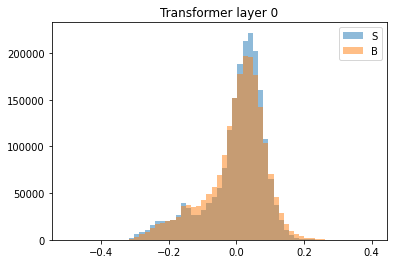

In [6]:
# Make the datasets

M1 = sig_reps
M2 = bkg_reps
bins = np.linspace(-.5,.4,60)

layer = 0
    
S = np.reshape(M1[:,layer,:], (M1.shape[0]*M1.shape[2],1))
B = np.reshape(M2[:,layer,:], (M2.shape[0]*M2.shape[2],1))



plt.figure()
plt.hist(S, bins, label = "S", alpha = 0.5)
plt.hist(B, bins, label = "B", alpha = 0.5)
plt.legend()
plt.title("Transformer layer "+str(layer))
plt.show()

Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)
On layer 0
Starting training...


 43%|████▎     | 430/1000 [00:57<01:15,  7.54it/s]


INFO: Early stopping
Finished Training


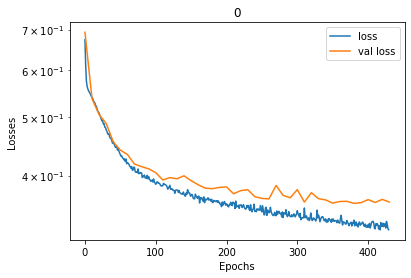

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


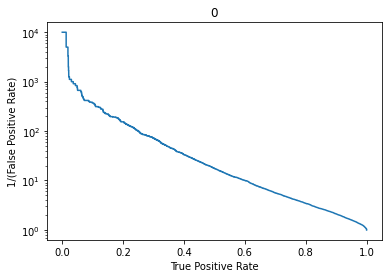

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


Accuracy of the network: 75 %
ROC AUC: 0.84550329
On layer 1
Starting training...


 29%|██▉       | 290/1000 [00:43<01:47,  6.61it/s]


INFO: Early stopping
Finished Training


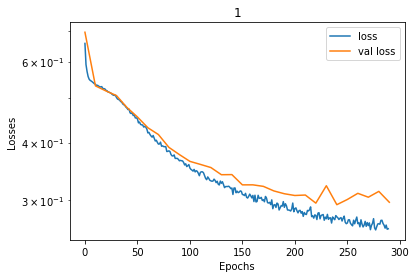

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


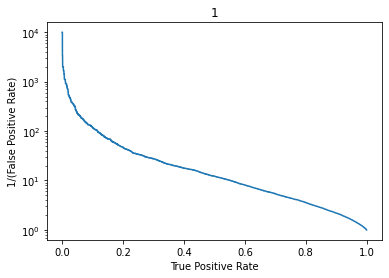

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


Accuracy of the network: 69 %
ROC AUC: 0.83458692
On layer 2
Starting training...


 10%|█         | 100/1000 [00:13<01:57,  7.67it/s]


INFO: Early stopping
Finished Training


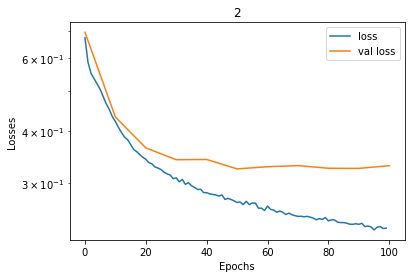

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


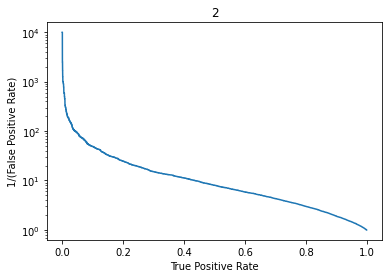

Accuracy of the network: 67 %
ROC AUC: 0.79778727


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


In [7]:
data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)

# print data dimensions
print( "Train data shape: " + str( data_train.shape ), flush=True)
print( "Train labels shape: " + str( labels_train.shape ), flush=True)
print( "Val data shape: " + str( data_val.shape ), flush=True)
print( "Val labels shape: " + str( labels_val.shape ), flush=True)


# Define the NN parameters

full_sup_AUC = {i:0 for i in range(3)}
full_sup_maxsic = {i:0 for i in range(3)}
fixed_TPR = 0.5
full_sup_FPRatTPR = {i:0 for i in range(3)}

input_shape = model_dim   
num_epochs = 1000
batch_size = 400
update_epochs = 10
lr = 0.001

# Run the NN

for trait in range(sig_reps.shape[1]): # going through the layers of the transformer
    
    print("On layer", trait)
    

    performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                          data_train[:,trait,:], labels_train, 
                          data_val[:,trait,:], labels_val,
                          STS_reps[:,trait,:], STS_labels, 
                          verbose = True, early_stop = True, LRschedule = False)
        

    # Plot the output losses   
    plt.figure()
    plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
    plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.yscale("log")
    plt.legend()
    plt.title(trait)
    plt.show()

    plt.figure()
    plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
    plt.yscale("log")
    plt.xlabel("True Positive Rate")
    plt.ylabel("1/(False Positive Rate)")
    plt.title(trait)
    plt.show()

    print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
    print("ROC AUC:", performance_stats["auc"])
    
    full_sup_AUC[trait] = performance_stats["auc"]
    
    SIC = performance_stats["tpr"]/np.sqrt(performance_stats["fpr"])
    finite_SIC = SIC[np.isfinite(SIC)]
    full_sup_maxsic[trait] = np.max(finite_SIC)
    
    dist_from_fixed_tpr = np.abs(performance_stats["tpr"] - fixed_TPR)
    min_dist_ind = np.where(dist_from_fixed_tpr == np.min(dist_from_fixed_tpr))[0][0]
    full_sup_FPRatTPR[trait] = np.sqrt(performance_stats["fpr"][min_dist_ind])
    
    


# Testing the classifier (CWoLa)

In [ ]:
# Define the NN parameters

input_shape = model_dim
num_epochs = 1000
batch_size = 400
update_epochs = 10
lr = 0.001

visualize = False

f1_vals = []
ROC_AUC_vals = {i:[] for i in range(3)}
maxsic_vals = {i:[] for i in range(3)}
FPRatTPR_vals = {i:[] for i in range(3)}

for f1 in np.linspace(0.5,.99,30):
    
    print("Starting CWoLa training run with f1 =", f1)
    f1_vals.append(f1)
    
    
    # make the datasets / mixed samples
    M1, M2 = generate_mixed_sample(sig_reps, bkg_reps, f1)
    data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)

    # print data dimensions
    print( "Train data shape: " + str( data_train.shape ), flush=True)
    print( "Train labels shape: " + str( labels_train.shape ), flush=True)
    print( "Val data shape: " + str( data_val.shape ), flush=True)
    print( "Val labels shape: " + str( labels_val.shape ), flush=True)

    # Run the NN

    for trait in range(sig_reps.shape[1]): # going through the layers of the transformer

        print("On layer", trait)
        
        # visualise the mixed samples
        
        if visualize:

            S = np.reshape(M1[:,trait,:], (M1.shape[0]*M1.shape[2],1))
            B = np.reshape(M2[:,trait,:], (M2.shape[0]*M2.shape[2],1))

            bins = np.linspace(-.5,.4,60)
            plt.figure()
            plt.hist(S, bins, label = "S", alpha = 0.5)
            plt.hist(B, bins, label = "B", alpha = 0.5)
            plt.legend()
            plt.title("Transformer layer "+str(trait))
            plt.show()

        performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                              data_train[:,trait,:], labels_train, 
                              data_val[:,trait,:], labels_val,
                              STS_reps[:,trait,:], STS_labels, 
                              verbose = True, early_stop = True, LRschedule = False)

        if visualize:
            # Plot the output losses   
            plt.figure()
            plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
            plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
            plt.xlabel("Epochs")
            plt.ylabel("Losses")
            plt.yscale("log")
            plt.legend()
            plt.title(trait)
            plt.show()

            plt.figure()
            plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
            plt.yscale("log")
            plt.xlabel("True Positive Rate")
            plt.ylabel("1/(False Positive Rate)")
            plt.title(trait)
            plt.show()

        print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
        print("ROC AUC:", performance_stats["auc"])
        
        ROC_AUC_vals[trait].append(performance_stats["auc"])
        
        SIC = performance_stats["tpr"]/np.sqrt(performance_stats["fpr"])
        finite_SIC = SIC[np.isfinite(SIC)]
        maxsic_vals[trait].append(np.max(finite_SIC))

        dist_from_fixed_tpr = np.abs(performance_stats["tpr"] - fixed_TPR)
        min_dist_ind = np.where(dist_from_fixed_tpr == np.min(dist_from_fixed_tpr))[0][0]
        FPRatTPR_vals[trait].append(np.sqrt(performance_stats["fpr"][min_dist_ind]))
    
        print()

        

Starting CWoLa training run with f1 = 0.5
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)
On layer 0
Starting training...


  5%|▌         | 50/1000 [00:06<02:03,  7.68it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 55 %
ROC AUC: 0.57760042

On layer 1
Starting training...


  6%|▌         | 60/1000 [00:06<01:45,  8.87it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 53 %
ROC AUC: 0.549597375

On layer 2
Starting training...


  5%|▌         | 50/1000 [00:04<01:19, 11.89it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 49 %
ROC AUC: 0.498989835

Starting CWoLa training run with f1 = 0.516896551724138
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


  5%|▌         | 50/1000 [00:04<01:20, 11.87it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 55 %
ROC AUC: 0.58696605

On layer 1
Starting training...


  6%|▌         | 60/1000 [00:05<01:25, 10.98it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 52 %
ROC AUC: 0.545712395

On layer 2
Starting training...


  5%|▌         | 50/1000 [00:04<01:34, 10.07it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 51 %
ROC AUC: 0.52025696

Starting CWoLa training run with f1 = 0.5337931034482759
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)
On layer 0
Starting training...


  6%|▌         | 60/1000 [00:06<01:35,  9.87it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 56 %
ROC AUC: 0.5690728649999999

On layer 1
Starting training...


  6%|▌         | 60/1000 [00:07<01:52,  8.38it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 55 %
ROC AUC: 0.57812102

On layer 2
Starting training...


  5%|▌         | 50/1000 [00:05<01:46,  8.96it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 53 %
ROC AUC: 0.53929633

Starting CWoLa training run with f1 = 0.5506896551724138
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


  9%|▉         | 90/1000 [00:07<01:14, 12.14it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 56 %
ROC AUC: 0.5777389749999999

On layer 1
Starting training...


  6%|▌         | 60/1000 [00:04<01:17, 12.19it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 55 %
ROC AUC: 0.57570973

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:04<01:16, 12.35it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 54 %
ROC AUC: 0.5615899

Starting CWoLa training run with f1 = 0.5675862068965517
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


  8%|▊         | 80/1000 [00:06<01:16, 12.10it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 61 %
ROC AUC: 0.65721477

On layer 1
Starting training...


  8%|▊         | 80/1000 [00:07<01:25, 10.72it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 60 %
ROC AUC: 0.6555143400000001

On layer 2
Starting training...


  5%|▌         | 50/1000 [00:04<01:27, 10.85it/s]

INFO: Early stopping
Finished Training
Accuracy of the network: 57 %
ROC AUC: 0.6011436499999999

Starting CWoLa training run with f1 = 0.5844827586206897
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)



/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


  9%|▉         | 90/1000 [00:09<01:31,  9.99it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 64 %
ROC AUC: 0.699663725

On layer 1
Starting training...


  7%|▋         | 70/1000 [00:05<01:15, 12.36it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 61 %
ROC AUC: 0.6624763650000001

On layer 2
Starting training...


  5%|▌         | 50/1000 [00:04<01:21, 11.66it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 60 %
ROC AUC: 0.6362238649999999

Starting CWoLa training run with f1 = 0.6013793103448276
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


  9%|▉         | 90/1000 [00:08<01:21, 11.22it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 64 %
ROC AUC: 0.69678765

On layer 1
Starting training...


  7%|▋         | 70/1000 [00:06<01:21, 11.47it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 61 %
ROC AUC: 0.6839761200000001

On layer 2
Starting training...


  5%|▌         | 50/1000 [00:04<01:19, 11.94it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 59 %
ROC AUC: 0.62920254

Starting CWoLa training run with f1 = 0.6182758620689655
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


  8%|▊         | 80/1000 [00:06<01:16, 12.10it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 63 %
ROC AUC: 0.68947466

On layer 1
Starting training...


 11%|█         | 110/1000 [00:09<01:14, 12.00it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 63 %
ROC AUC: 0.6819154700000001

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:05<01:24, 11.06it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 61 %
ROC AUC: 0.6651018200000001

Starting CWoLa training run with f1 = 0.6351724137931034
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


  9%|▉         | 90/1000 [00:07<01:19, 11.48it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 63 %
ROC AUC: 0.7096234050000001

On layer 1
Starting training...


  7%|▋         | 70/1000 [00:06<01:20, 11.50it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 61 %
ROC AUC: 0.69017506

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:05<01:21, 11.49it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 61 %
ROC AUC: 0.658900495

Starting CWoLa training run with f1 = 0.6520689655172414
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 22%|██▏       | 220/1000 [00:18<01:07, 11.58it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.73758274

On layer 1
Starting training...


  7%|▋         | 70/1000 [00:06<01:26, 10.69it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 64 %
ROC AUC: 0.702525765

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:04<01:17, 12.15it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 61 %
ROC AUC: 0.67322893

Starting CWoLa training run with f1 = 0.6689655172413793
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 20%|██        | 200/1000 [00:17<01:08, 11.67it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 67 %
ROC AUC: 0.739435285

On layer 1
Starting training...


  6%|▌         | 60/1000 [00:05<01:19, 11.81it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 65 %
ROC AUC: 0.7155979549999999

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:05<01:19, 11.87it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 65 %
ROC AUC: 0.697893645

Starting CWoLa training run with f1 = 0.6858620689655173
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 18%|█▊        | 180/1000 [00:16<01:14, 11.06it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.7421653349999999

On layer 1
Starting training...


 12%|█▏        | 120/1000 [00:11<01:20, 10.91it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 65 %
ROC AUC: 0.72039267

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:05<01:19, 11.89it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 64 %
ROC AUC: 0.71288417

Starting CWoLa training run with f1 = 0.7027586206896552
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 23%|██▎       | 230/1000 [00:23<01:19,  9.70it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.74645323

On layer 1
Starting training...


 16%|█▌        | 160/1000 [00:14<01:17, 10.78it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.7274834299999999

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:05<01:20, 11.66it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 64 %
ROC AUC: 0.708257485

Starting CWoLa training run with f1 = 0.7196551724137931
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)
On layer 0
Starting training...


 29%|██▉       | 290/1000 [00:25<01:02, 11.40it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 69 %
ROC AUC: 0.7723557999999999

On layer 1
Starting training...


 23%|██▎       | 230/1000 [00:28<01:36,  7.94it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 67 %
ROC AUC: 0.743716515

On layer 2
Starting training...


  6%|▌         | 60/1000 [00:05<01:22, 11.36it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 65 %
ROC AUC: 0.7175790449999999

Starting CWoLa training run with f1 = 0.736551724137931
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)
On layer 0
Starting training...


 20%|██        | 200/1000 [00:17<01:10, 11.40it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 69 %
ROC AUC: 0.7815896099999999

On layer 1
Starting training...


 29%|██▉       | 290/1000 [00:24<01:00, 11.72it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.75937793

On layer 2
Starting training...


  8%|▊         | 80/1000 [00:08<01:34,  9.73it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 64 %
ROC AUC: 0.7302576900000001

Starting CWoLa training run with f1 = 0.7534482758620689
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)
On layer 0
Starting training...


 24%|██▍       | 240/1000 [00:20<01:05, 11.56it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 67 %
ROC AUC: 0.765613385

On layer 1
Starting training...


 22%|██▏       | 220/1000 [00:19<01:10, 11.13it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 68 %
ROC AUC: 0.767019295

On layer 2
Starting training...


  7%|▋         | 70/1000 [00:05<01:18, 11.91it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 65 %
ROC AUC: 0.733160015

Starting CWoLa training run with f1 = 0.7703448275862068
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 23%|██▎       | 230/1000 [00:19<01:05, 11.68it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 71 %
ROC AUC: 0.788567545

On layer 1
Starting training...


 20%|██        | 200/1000 [00:16<01:07, 11.83it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 67 %
ROC AUC: 0.76570599

On layer 2
Starting training...


  9%|▉         | 90/1000 [00:07<01:17, 11.81it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 65 %
ROC AUC: 0.7350033850000001

Starting CWoLa training run with f1 = 0.7872413793103448
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 22%|██▏       | 220/1000 [00:18<01:06, 11.73it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 72 %
ROC AUC: 0.79634039

On layer 1
Starting training...


 38%|███▊      | 380/1000 [00:31<00:51, 11.98it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 68 %
ROC AUC: 0.7766690700000001

On layer 2
Starting training...


  8%|▊         | 80/1000 [00:06<01:19, 11.60it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.7471565350000001

Starting CWoLa training run with f1 = 0.8041379310344827
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 47%|████▋     | 470/1000 [00:44<00:49, 10.67it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 72 %
ROC AUC: 0.810402045

On layer 1
Starting training...


 30%|███       | 300/1000 [00:33<01:18,  8.87it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 69 %
ROC AUC: 0.783756755

On layer 2
Starting training...


 10%|█         | 100/1000 [00:12<01:52,  7.98it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.754875385

Starting CWoLa training run with f1 = 0.8210344827586207
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 27%|██▋       | 270/1000 [00:23<01:03, 11.44it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 71 %
ROC AUC: 0.8113315349999999

On layer 1
Starting training...


 24%|██▍       | 240/1000 [00:20<01:06, 11.50it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


INFO: Early stopping
Finished Training
Accuracy of the network: 68 %
ROC AUC: 0.780033085

On layer 2
Starting training...


  8%|▊         | 80/1000 [00:06<01:17, 11.80it/s]


INFO: Early stopping
Finished Training
Accuracy of the network: 66 %
ROC AUC: 0.7559286000000001

Starting CWoLa training run with f1 = 0.8379310344827586
Train data shape: (22260, 3, 128)
Train labels shape: (22260,)
Val data shape: (9540, 3, 128)
Val labels shape: (9540,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


On layer 0
Starting training...


 18%|█▊        | 178/1000 [00:15<01:19, 10.32it/s]

In [17]:
cwola_npy_save_dict = "CWoLa_results_npy/dim_"+str(model_dim)+"/"

# save the f1 vals scanned over
np.save(cwola_npy_save_dict+"f1_vals"+"_seed"+str(seed), f1_vals)


for layer in range(3):
    
    # save the full sup 
    np.save(cwola_npy_save_dict+"full_sup_AUC_layer"+str(layer)+"_seed"+str(seed), np.full(len(f1_vals), full_sup_AUC[layer]))
    np.save(cwola_npy_save_dict+"full_sup_maxsic"+str(layer)+"_seed"+str(seed), np.full(len(f1_vals), full_sup_maxsic[layer]))
    np.save(cwola_npy_save_dict+"full_sup_FPRatTPR"+str(layer)+"_seed"+str(seed), np.full(len(f1_vals), full_sup_FPRatTPR[layer]))
    
    # save the Cwola
    np.save(cwola_npy_save_dict+"CWoLa_AUC_layer"+str(layer)+"_seed"+str(seed), [max(x, 1.0-x) for x in ROC_AUC_vals[layer]])
    np.save(cwola_npy_save_dict+"CWoLa_sup_maxsic"+str(layer)+"_seed"+str(seed), maxsic_vals[layer])
    np.save(cwola_npy_save_dict+"CWoLa_sup_FPRatTPR"+str(layer)+"_seed"+str(seed), FPRatTPR_vals[layer])
    


In [5]:
# Plotting

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("science.mplstyle")
from matplotlib.backends.backend_pdf import PdfPages

model_dim = 128

seeds = [1,2,3]

cwola_npy_save_dict = "CWoLa_results_npy/dim_"+str(model_dim)+"/"


full_sup_results_dict = {seed:{"AUC":{0:0,1:0,2:0},
                        "maxsic":{0:0,1:0,2:0},
                        "FPRatTPR":{0:0,1:0,2:0},} for seed in seeds}

cwola_results_dict = {seed:{"AUC":{0:0,1:0,2:0},
                        "maxsic":{0:0,1:0,2:0},
                        "FPRatTPR":{0:0,1:0,2:0},} for seed in seeds}


for seed in seeds:
    for layer in range(3):
        full_sup_results_dict[seed]["AUC"][layer] = np.load(cwola_npy_save_dict+"full_sup_AUC_layer"+str(layer)+"_seed"+str(seed)+".npy")
        full_sup_results_dict[seed]["maxsic"][layer] = np.load(cwola_npy_save_dict+"full_sup_maxsic"+str(layer)+"_seed"+str(seed)+".npy")
        full_sup_results_dict[seed]["FPRatTPR"][layer] = np.load(cwola_npy_save_dict+"full_sup_FPRatTPR"+str(layer)+"_seed"+str(seed)+".npy")

        cwola_results_dict[seed]["AUC"][layer] = np.load(cwola_npy_save_dict+"CWoLa_AUC_layer"+str(layer)+"_seed"+str(seed)+".npy")
        cwola_results_dict[seed]["maxsic"][layer] = np.load(cwola_npy_save_dict+"CWoLa_sup_maxsic"+str(layer)+"_seed"+str(seed)+".npy")
        cwola_results_dict[seed]["FPRatTPR"][layer] = np.load(cwola_npy_save_dict+"CWoLa_sup_FPRatTPR"+str(layer)+"_seed"+str(seed)+".npy")

f1_vals = np.load(cwola_npy_save_dict+"f1_vals_seed"+str(1)+".npy")


# for eahc f1 val, calculate the mean and std from the seeds
avg_full_sup_results_dict = {"AUC":{0:[[],[]],1:[[],[]],2:[[],[]]},  # vals, errors
                        "maxsic":{0:[[],[]],1:[[],[]],2:[[],[]]},
                        "FPRatTPR":{0:[[],[]],1:[[],[]],2:[[],[]]},}
avg_cwola_results_dict = {"AUC":{0:[[],[]],1:[[],[]],2:[[],[]]},
                        "maxsic":{0:[[],[]],1:[[],[]],2:[[],[]]},
                        "FPRatTPR":{0:[[],[]],1:[[],[]],2:[[],[]]},}

print(avg_full_sup_results_dict)

for layer in range(3):
    for i in range(len(f1_vals)):
        avg_full_sup_results_dict["AUC"][layer][0].append(np.mean([full_sup_results_dict[seed]["AUC"][layer][i] for seed in seeds]))
        avg_full_sup_results_dict["AUC"][layer][1].append(np.std([full_sup_results_dict[seed]["AUC"][layer][i] for seed in seeds]))
        avg_full_sup_results_dict["maxsic"][layer][0].append(np.mean([full_sup_results_dict[seed]["maxsic"][layer][i] for seed in seeds]))
        avg_full_sup_results_dict["maxsic"][layer][1].append(np.std([full_sup_results_dict[seed]["maxsic"][layer][i] for seed in seeds]))
        avg_full_sup_results_dict["FPRatTPR"][layer][0].append(np.mean([full_sup_results_dict[seed]["FPRatTPR"][layer][i] for seed in seeds]))
        avg_full_sup_results_dict["FPRatTPR"][layer][1].append(np.std([full_sup_results_dict[seed]["FPRatTPR"][layer][i] for seed in seeds]))

        avg_cwola_results_dict["AUC"][layer][0].append(np.mean([cwola_results_dict[seed]["AUC"][layer][i] for seed in seeds]))
        avg_cwola_results_dict["AUC"][layer][1].append(np.std([cwola_results_dict[seed]["AUC"][layer][i] for seed in seeds]))
        avg_cwola_results_dict["maxsic"][layer][0].append(np.mean([cwola_results_dict[seed]["maxsic"][layer][i] for seed in seeds]))
        avg_cwola_results_dict["maxsic"][layer][1].append(np.std([cwola_results_dict[seed]["maxsic"][layer][i] for seed in seeds]))
        avg_cwola_results_dict["FPRatTPR"][layer][0].append(np.mean([cwola_results_dict[seed]["FPRatTPR"][layer][i] for seed in seeds]))
        avg_cwola_results_dict["FPRatTPR"][layer][1].append(np.std([cwola_results_dict[seed]["FPRatTPR"][layer][i] for seed in seeds]))




{'AUC': {0: [[], []], 1: [[], []], 2: [[], []]}, 'maxsic': {0: [[], []], 1: [[], []], 2: [[], []]}, 'FPRatTPR': {0: [[], []], 1: [[], []], 2: [[], []]}}


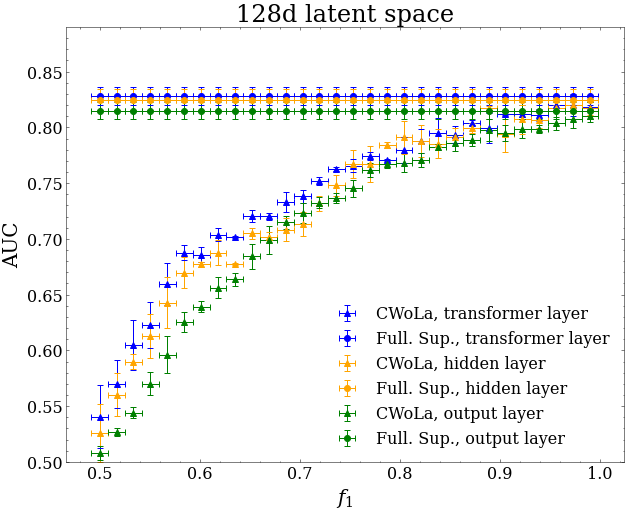

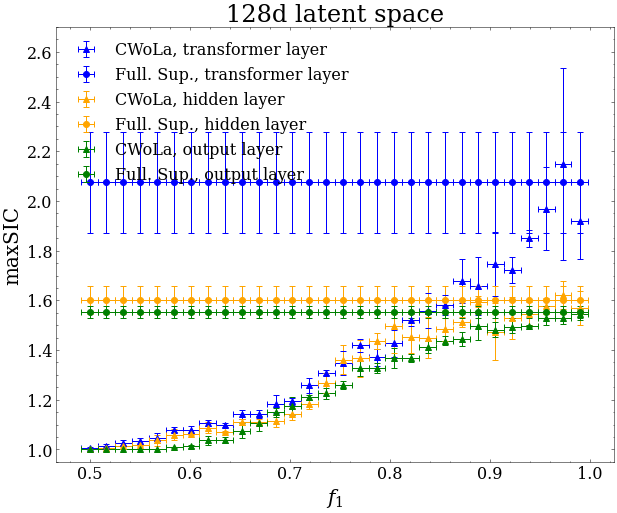

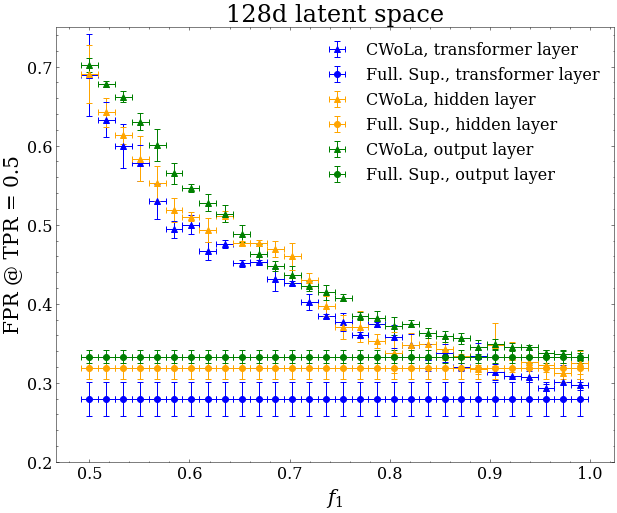

In [6]:



pdf_name = "JetCLR_CWoLa_"+str(model_dim)+".pdf"
pp = PdfPages(pdf_name)

layer_colors = {0:"blue", 1:"orange", 2:"green"}
layer_labels = {0:"transformer layer", 1:"hidden layer", 2:"output layer"}

capsize = 3
xerr = .5*(f1_vals[1] - f1_vals[0])
    
fig = plt.figure(figsize = (10,8))
for layer in range(3):
    plt.errorbar(f1_vals, avg_cwola_results_dict["AUC"][layer][0], yerr = avg_cwola_results_dict["AUC"][layer][1], label = "CWoLa, "+layer_labels[layer], capsize = capsize, fmt = "^", xerr = xerr, color = layer_colors[layer])
    plt.errorbar(f1_vals, avg_full_sup_results_dict["AUC"][layer][0], yerr = avg_full_sup_results_dict["AUC"][layer][1], label = "Full. Sup., "+layer_labels[layer], capsize = capsize, fmt = "o", xerr = xerr, color = layer_colors[layer])
plt.legend()
plt.ylim(0.5, 0.89)
plt.xlabel("$f_1$")
plt.ylabel("AUC")
plt.title(str(model_dim)+"d latent space")
plt.show()
pp.savefig(fig)


fig = plt.figure(figsize = (10,8))
for layer in range(3):
    plt.errorbar(f1_vals, avg_cwola_results_dict["maxsic"][layer][0], yerr = avg_cwola_results_dict["maxsic"][layer][1], label = "CWoLa, "+layer_labels[layer], capsize = capsize, fmt = "^", xerr = xerr, color = layer_colors[layer])
    plt.errorbar(f1_vals, avg_full_sup_results_dict["maxsic"][layer][0], yerr = avg_full_sup_results_dict["maxsic"][layer][1], label = "Full. Sup., "+layer_labels[layer], capsize = capsize, fmt = "o", xerr = xerr, color = layer_colors[layer])
plt.legend()
plt.xlabel("$f_1$")
plt.ylim(0.95, 2.7)
plt.ylabel("maxSIC")
plt.title(str(model_dim)+"d latent space")
plt.show()
pp.savefig(fig)

fig = plt.figure(figsize = (10,8))
for layer in range(3):
    plt.errorbar(f1_vals, avg_cwola_results_dict["FPRatTPR"][layer][0], yerr = avg_cwola_results_dict["FPRatTPR"][layer][1], label = "CWoLa, "+layer_labels[layer], capsize = capsize, fmt = "^", xerr = xerr, color = layer_colors[layer])
    plt.errorbar(f1_vals, avg_full_sup_results_dict["FPRatTPR"][layer][0], yerr = avg_full_sup_results_dict["FPRatTPR"][layer][1], label = "Full. Sup., "+layer_labels[layer], capsize = capsize, fmt = "o", xerr = xerr, color = layer_colors[layer])
plt.legend()
plt.xlabel("$f_1$")
plt.ylabel("FPR @ TPR = 0.5")
plt.ylim(0.2, 0.75)
plt.title(str(model_dim)+"d latent space")
plt.show()
pp.savefig(fig)


pp.close()


